<a href="https://colab.research.google.com/github/yoance/HPINN/blob/main/H-PINN%20-%20KdV%20Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KdV Equation

# 1. Import the required Library and Package.

The code can be run with TensorFlow version `2.5.x`.
The model implementation is done with the library NumPy and the library for machine learning TensorFlow.

A class implementation has been developed for creating the PINN as an object of Keras in a package stored in the file `PINNPDESolver.py`.

Computation is performed on Google Colab.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Current Working Directory
dir = '/content/drive/My Drive/Tugas Akhir/Colab'

import sys
sys.path.insert(0, dir)

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Physics-Informed Neural Network
import PINNPDESolver as pinn

# Import Combined Learning Rate Decay
from CombinedDecay import CombinedDecay

# Import time
from time import time

# Import matplotlib for plots
import matplotlib.pyplot as plt

# Creating tables
import pandas as pd
from tabulate import tabulate

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 24,               # LaTeX default is 10pt font.
    "font.size": 24,
    "legend.fontsize": 24,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
plt.rcParams.update(pgf_with_latex)

In [ ]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# 2. Korteweg-de Vries (KdV) 1-Soliton Equation and Transformation into Loss Function

The KdV equation to be used is

$$
\begin{equation}
    u_t - 6uu_{x} + u_{xxx} = 0, \quad -\infty<x<\infty, \quad t>0
\end{equation}.
$$
Given the initial condition (IC)
$$
\begin{equation}
    u(x,\,0) = -2sech^2(x).
\end{equation}
$$
The unique solution to this problem is
$$
\begin{equation}
	        u(x,\;t) = -2sech^2(x-4t).
\end{equation}
$$


In [ ]:
lambda_star = [-6, 1]

# Define initial condition
def fun_u_0(x):
    return -2 * 1/(tf.math.cosh(x))**2

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, lambd = lambda_star):
    return u_t + lambd[0] * u * u_x + lambd[1] * u_xxx

In [ ]:
# Explicit Solution
def u_expl(t, x):
    """Explicit Solution to the KdV Equation."""
    return -2 * 1/(np.cosh(x-4*t))**2

In [ ]:
# Set boundary
tmin = -1.
tmax = 1.
xmin = -10.
xmax = 10.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# 3. Modeling

## 1. Preparation for Modeling


### Generating Training Data and Collocation Points for Inverse Problems

In [ ]:
N_d = 500
noise = 0.0

plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:
  # Draw points with measurements randomly
  t_d = tf.random.uniform((N_d,1), lb[0], ub[0], dtype=DTYPE)
  x_d = tf.random.uniform((N_d,1), lb[1], ub[1], dtype=DTYPE)
  X_d = tf.concat([t_d, x_d], axis=1)

  # Explicit analytical solution
  u_d = u_expl(t_d, x_d)
  u_d += noise * tf.random.normal(u_d.shape, dtype=DTYPE)

elif plot == False:
  X_d, u_d = pinn.generate_collocation_points(N_d, lb, ub, u_expl, noise=0)

X_param = [X_d]
u_param = [u_d]

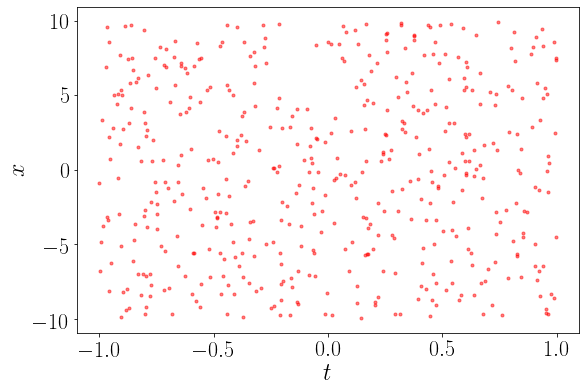

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_d, x_d, c='r', marker='.', alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('$x$')

# plt.title('(b) Visualisasi koordinat data $\it{training}$ dan $\it{collocation\;points}$ untuk masalah invers persamaan KdV.');
# plt.savefig('kdv_eqn_inv_train.pdf', bbox_inches='tight', dpi=600, facecolor='none')

plt.show()

### Preparation of the PINN Architecture

In the first hidden layer, there are $2 \times 20 = 40$ weight parameters and $20$ bias parameters. In the subsequent hidden layers, there are $20 \times 20 = 400$ weight parameters and $20$ bias parameters in each layer. In the output layer connected to the last hidden layer, there are $1 \times 20 = 20$ weight parameters and $20$ bias parameters.

Thus, there is a total of:
\begin{align*}
    1 \times (40+20) + 1 \times (400+20) + 1 \times (20+20) = 520
\end{align*}
parameters that can be determined and updated in each epoch within the PINN model.


In [ ]:
arch = {'output_dim':1, 'num_hidden_layers':2, 'num_neurons_per_layer':20}
n_models = 5

In [ ]:
models = [None] * n_models

for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.PINN_IdentificationNet(initial_lambda=[0.0, 0.0], lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

### Preparation for Calculating the Loss Function


In [ ]:
def get_r(t, x, model, fun_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape1:

        tape1.watch(x)
        with tf.GradientTape(persistent=True) as tape2:

          tape2.watch(x)
          with tf.GradientTape(persistent=True) as tape3:

            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape3.watch(t)
            tape3.watch(x)

            # Determine residual
            u = model(tf.stack([t[:,0], x[:,0]], axis=1))

          # Compute gradient u_x and u_t
          u_t = tape3.gradient(u, t)
          u_x = tape3.gradient(u, x)

        u_xx = tape2.gradient(u_x, x)

    u_xxx = tape1.gradient(u_xx, x)

    del tape1
    del tape2
    del tape3

    return fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, model)

def fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, model):
    return u_t + model.lambd[0] * u * u_x + model.lambd[1] * u_xxx

In [ ]:
def get_r_param(t, x, model):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        # t, x = X_r[:, 0:1], X_r[:,1:2]

        tape.watch(x)
        with tf.GradientTape(persistent=True) as tape2:

          tape2.watch(x)
          with tf.GradientTape(persistent=True) as tape3:
            tape3.watch(t)
            tape3.watch(x)

            # Determine residual
            u = model(tf.stack([t[:,0], x[:,0]], axis=1))

          u_t = tape3.gradient(u, t)
          u_x = tape3.gradient(u, x)

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_xx = tape2.gradient(u_x, x)


    u_xxx = tape.gradient(u_xx, x)

    del tape
    del tape2
    del tape3

    with tf.GradientTape(persistent=True) as tape_lambd:
      tape_lambd.watch(model.lambd)
      r = u_t + model.lambd[0] * u * u_x + model.lambd[1] * u_xxx
      loss = tf.reduce_mean(tf.square(r))

    g = tape_lambd.gradient(loss, model.lambd)

    del tape_lambd

    return loss, g

## 2. Preparation of the Optimizer

Since less data is used for the inverse problem case, the number of iterations in the gradient descent-based optimizer will increase. Therefore, the boundary for the learning rate to be used in the Piecewise Constant Decay must be larger.

In [ ]:
# lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# # Choose the optimizer
# optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_pw)
# optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_pw)

# boundaries = [3000,7000]
# values = [1e-1,1e-2,1e-3]
lr_comb_param = {'boundaries': [3000,7000,14000],
                 'initial_learning_rate': 1e-1,
                 'decay_steps': 150,
                 'decay_rate': 0.9,
                 'values_steps': 2}
lr_comb = CombinedDecay(**lr_comb_param)
lr_comb.get_config()

{'initial_learning_rate': 0.1,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [3000, 7000, 14000],
 'values': [0.012157665459056936,
  0.006078832729528468,
  0.003039416364764234,
  0.001519708182382117],
 'values_steps': [2, 2, 2],
 'name': None}

## 3. Model Training

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [[0.0, 0.0], [1.0, -6.0], [10.0, 10.0]]
path = dir + "/model weights/kdv_eqn_inv"

old_timeout = timeout
models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models


for i in range(n_models):
  timeout = old_timeout
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    # Prepare models' architecture
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))

    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_LBFGS[i][j].set_weights(models[i].get_weights())
    models_SGD[i][j].set_weights(models[i].get_weights())
    models_Adam[i][j].set_weights(models[i].get_weights())

    # Assigning initial lambda
    models_LBFGS[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_SGD[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_Adam[i][j].trainable_variables[-1].assign(initial_lambdas[j])

    # Prepare optimizer
    optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_comb)
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_LBFGS = pinn.PINN_IdentificationSolver(models_LBFGS[i][j], X_d, fun_r, get_r)
    solver_SGD = pinn.PINN_IdentificationSolver(models_SGD[i][j], X_d, fun_r, get_r)
    solver_Adam = pinn.PINN_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nL-BFGS\n')
    solver_LBFGS.solve_with_ScipyOptimizer(X_param, u_param,
                                          timeout=timeout,
                                          method='L-BFGS-B')
    print('\n\nSGD\n')
    solver_SGD.solve_with_TFoptimizer(optim_SGD, X_param, u_param, timeout=timeout)
    print('\n\nAdam\n')
    solver_Adam.solve_with_TFoptimizer(optim_Adam, X_param, u_param, timeout=timeout)

    # Store evolution of lambdas and hists
    hists_LBFGS[i].append(np.array([models_LBFGS[i][j].lambd_list, solver_LBFGS.hist]))
    hists_SGD[i].append(np.array([models_SGD[i][j].lambd_list, solver_SGD.hist]))
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_Adam.hist]))

    hists_LBFGS[i][j] = np.column_stack((np.stack(hists_LBFGS[i][j][0], axis=0), hists_LBFGS[i][j][1]))
    hists_SGD[i][j] = np.column_stack((np.stack(hists_SGD[i][j][0], axis=0), hists_SGD[i][j][1]))
    hists_Adam[i][j] = np.column_stack((np.stack(hists_Adam[i][j][0], axis=0), hists_Adam[i][j][1]))

    print('\n\n\n')

--------------------------------------------------
Iteration: 1 Initial lambda: [0.0, 0.0]
--------------------------------------------------


L-BFGS

It 00000: loss = 2.58083671e-01 lambda = [-3.4764460e-06 -1.1897985e-06]
It 00050: loss = 1.52042001e-01 lambda = [-0.6725802 -0.4526452]
It 00100: loss = 8.94438773e-02 lambda = [-4.1198273  0.1602027]
It 00150: loss = 1.17732007e-02 lambda = [-5.2874403   0.59955394]
It 00200: loss = 3.74858826e-03 lambda = [-5.220403   0.7202463]
It 00250: loss = 1.46021089e-03 lambda = [-5.4984336   0.78801507]
It 00300: loss = 4.27827676e-04 lambda = [-5.7718287   0.92154473]
It 00350: loss = 2.19210182e-04 lambda = [-5.8913536  0.9681635]
It 00400: loss = 1.39220443e-04 lambda = [-5.966344    0.98368007]
It 00450: loss = 8.74988255e-05 lambda = [-6.0250363  1.003382 ]
It 00500: loss = 5.47622403e-05 lambda = [-6.02119    1.0044199]
It 00550: loss = 3.86812644e-05 lambda = [-6.0201488  1.0116858]
It 00600: loss = 2.14638276e-05 lambda = [-6.034956 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
It 22200: loss = 6.75186016e-07 lambda = [-5.999983   0.9999838]
It 22250: loss = 8.15905821e-07 lambda = [-6.0000186   0.99990886]
It 22300: loss = 9.27802830e-07 lambda = [-5.9999676  1.0000068]
It 22350: loss = 6.71537009e-07 lambda = [-5.999989   0.9999885]
It 22400: loss = 2.02010915e-06 lambda = [-5.9999948  0.9999782]
It 22450: loss = 1.00423904e-06 lambda = [-5.999977   0.9999901]
It 22500: loss = 5.22123128e-06 lambda = [-6.000014   0.9999526]
It 22550: loss = 6.83922224e-07 lambda = [-5.99999    0.9999893]
It 22600: loss = 6.59331477e-07 lambda = [-5.9999914  0.9999875]
It 22650: loss = 2.69173070e-05 lambda = [-6.0000257  0.9998983]
It 22700: loss = 7.78529056e-07 lambda = [-5.9999785  0.99999  ]
It 22750: loss = 6.59545947e-07 lambda = [-5.9999833  0.999987 ]
It 22800: loss = 7.43285909e-07 lambda = [-5.9999747  0.9999832]
It 22850: loss = 6.71662690e-07 lambda = [-5.999983    0.99998546]
It 22900: loss = 5.36189364e-05 lam

### Exporting the Model

Export the weights and biases obtained during training.

In [ ]:
path = dir + "/model weights/kdv_eqn_inv"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_LBFGS[i][j].save_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].save_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].save_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

Export the training loss progression as `hist`.

In [ ]:
for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt", hists_LBFGS[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt", hists_SGD[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt", hists_Adam[i][j])

### Importing the Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [[0.0, 0.0], [1.0, -6.0], [10.0, 10.0]]
path = dir + "/model weights/kdv_eqn_inv"

models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models

for i in range(n_models):
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))

    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    models_LBFGS[i][j].load_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].load_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].load_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

    hists_LBFGS[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt"))
    hists_SGD[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt"))
    hists_Adam[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt"))

## Prediction Analysis

In [ ]:
def lambdas(hists, iter_model, iter_init, lambd_init, N=500):
  return sum(hists[iter_model][iter_init][-N:,lambd_init]) / N

cols = ['L-BFGS_0', 'L-BFGS_1',
        'SGD_0', 'SGD_1',
        'Adam_0', 'Adam_1']
df1 = pd.DataFrame(columns = cols)
df2 = pd.DataFrame(columns = cols)
df3 = pd.DataFrame(columns = cols)

for i in range(n_models):
  x = []
  x.append(lambdas(hists_LBFGS, i, 0, 0)); x.append(lambdas(hists_LBFGS, i, 0, 1))
  x.append(lambdas(hists_SGD, i, 0, 0)); x.append(lambdas(hists_SGD, i, 0, 1))
  x.append(lambdas(hists_Adam, i, 0, 0)); x.append(lambdas(hists_Adam, i, 0, 1))
  df1.loc['Attempt '+str(i+1)] = x

df1.loc['Average'] = df1.mean(axis=0)

for i in range(n_models):
  x = []
  x.append(lambdas(hists_LBFGS, i, 1, 0)); x.append(lambdas(hists_LBFGS, i, 1, 1))
  x.append(lambdas(hists_SGD, i, 1, 0)); x.append(lambdas(hists_SGD, i, 1, 1))
  x.append(lambdas(hists_Adam, i, 1, 0)); x.append(lambdas(hists_Adam, i, 1, 1))
  df2.loc['Attempt '+str(i+1)] = x

df2.loc['Average'] = df2.mean(axis=0)

for i in range(n_models):
  x = []
  x.append(lambdas(hists_LBFGS, i, 2, 0)); x.append(lambdas(hists_LBFGS, i, 2, 1))
  x.append(lambdas(hists_SGD, i, 2, 0)); x.append(lambdas(hists_SGD, i, 2, 1))
  x.append(lambdas(hists_Adam, i, 2, 0)); x.append(lambdas(hists_Adam, i, 2, 1))
  df3.loc['Attempt '+str(i+1)] = x

df3.loc['Average'] = df3.mean(axis=0)

In [ ]:
print(tabulate(df1.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))
print(tabulate(df2.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))
print(tabulate(df3.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrr}
\hline
           &   L-BFGS\_0 &   L-BFGS\_1 &   SGD\_0 &   SGD\_1 &   Adam\_0 &   Adam\_1 \\
\hline
 Attempt 1 &    -5.9888 &     0.9962 & -0.8925 & -0.5300 &  -6.0000 &   1.0000 \\
 Attempt 2 &    -5.9940 &     0.9976 & -0.8844 & -0.5951 &  -5.9998 &   1.0000 \\
 Attempt 3 &    -6.0031 &     1.0013 & -1.2734 & -0.8983 &  -6.0006 &   1.0002 \\
 Attempt 4 &    -6.0053 &     1.0022 & -1.4010 & -0.9241 &  -6.0000 &   1.0000 \\
 Attempt 5 &    -6.0674 &     1.0259 & -1.3908 & -0.9049 &  -6.0001 &   1.0000 \\
 Average   &    -6.0117 &     1.0046 & -1.1684 & -0.7705 &  -6.0001 &   1.0000 \\
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
\hline
           &   L-BFGS\_0 &   L-BFGS\_1 &   SGD\_0 &   SGD\_1 &   Adam\_0 &   Adam\_1 \\
\hline
 Attempt 1 &    -3.8661 &    -0.7705 &  0.5554 & -6.0954 &  -5.9995 &   0.9998 \\
 Attempt 2 &    -3.8347 &    -0.8067 &  0.5511 & -6.0340 &  -5.9997 &   0.9999 \\
 Attempt 3 &    -3.7654 &    -0.8907 &  0.4996 & -6.0623 &  -5.9965 &

## H-PINN Training

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [[0.0, 0.0], [1.0, -6.0], [10.0, 10.0]]
path = dir + "/model weights/kdv_eqn_inv"

old_timeout = timeout
models = [None] * n_models
models_Adam = [None] * n_models
hists_Adam = [None] * n_models
hists_Adam = [None] * n_models
lambds_Adam = [None] * n_models
losses_Adam = [None] * n_models


for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.Hybrid_IdentificationNet(initial_lambda=0.0, lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

  timeout = old_timeout
  models_Adam[i] = []
  hists_Adam[i] = []
  lambds_Adam[i] = []
  losses_Adam[i] = []

  for j in range(len(initial_lambdas)):
    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    models_Adam[i].append(pinn.Hybrid_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_Adam[i][j].set_weights(models[i].get_weights())

    # Assigning initial lambda
    models_Adam[i][j].initial_lambda = initial_lambdas[j]

    # Prepare optimizer for learning given data
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Prepare optimizer for minimizing PDE function and finding PDE parameters
    optim_inv_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_hybrid = pinn.Hybrid_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nAdam\n')
    solver_hybrid.solve(optim_Adam, optim_inv_Adam, get_r_param, X_param, u_param,
                        timeout_param=timeout*0.8, timeout=timeout*0.2)

    # Store evolution of lambdas and hists
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_hybrid.hist]))
    lambds_Adam[i].append(np.stack(hists_Adam[i][j][0], axis=0))
    losses_Adam[i].append(hists_Adam[i][j][1])

    print('\n\n\n')

--------------------------------------------------
Iteration: 1 Initial lambda: [0.0, 0.0]
--------------------------------------------------


Adam

Initial Learning Rate = 1.00000e-01
It 00000: l_u = 3.31840247e-01 loss = 3.31840247e-01
It 00050: l_u = 3.36617045e-03 loss = 3.36617045e-03
It 00100: l_u = 2.42268899e-03 loss = 2.42268899e-03
It 00150: l_u = 1.05786276e-04 loss = 1.05786276e-04
It 00200: l_u = 5.87090726e-05 loss = 5.87090726e-05
It 00250: l_u = 3.57485333e-05 loss = 3.57485333e-05
It 00300: l_u = 2.17353669e-03 loss = 2.17353669e-03
It 00350: l_u = 2.79217784e-05 loss = 2.79217784e-05
It 00400: l_u = 1.44473170e-05 loss = 1.44473170e-05
It 00450: l_u = 1.09469902e-05 loss = 1.09469902e-05
It 00500: l_u = 8.84935980e-06 loss = 8.84935980e-06
It 00550: l_u = 7.50259142e-06 loss = 7.50259142e-06
It 00600: l_u = 6.59669104e-06 loss = 6.59669104e-06
It 00650: l_u = 5.95301708e-06 loss = 5.95301708e-06
It 00700: l_u = 5.46838237e-06 loss = 5.46838237e-06
It 00750: l_u = 5.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


It 00000: l_u = 3.31840247e-01 loss = 3.31840247e-01
It 00050: l_u = 3.36616556e-03 loss = 3.36616556e-03
It 00100: l_u = 2.42840126e-03 loss = 2.42840126e-03
It 00150: l_u = 1.05467603e-04 loss = 1.05467603e-04
It 00200: l_u = 5.87070172e-05 loss = 5.87070172e-05
It 00250: l_u = 3.57601675e-05 loss = 3.57601675e-05
It 00300: l_u = 1.41117442e-03 loss = 1.41117442e-03
It 00350: l_u = 2.18808473e-05 loss = 2.18808473e-05
It 00400: l_u = 1.43015322e-05 loss = 1.43015322e-05
It 00450: l_u = 1.08932591e-05 loss = 1.08932591e-05
It 00500: l_u = 8.80792322e-06 loss = 8.80792322e-06
It 00550: l_u = 7.47248987e-06 loss = 7.47248987e-06
It 00600: l_u = 6.57605597e-06 loss = 6.57605597e-06
It 00650: l_u = 5.93977757e-06 loss = 5.93977757e-06
It 00700: l_u = 5.46068031e-06 loss = 5.46068031e-06
It 00750: l_u = 5.08015046e-06 loss = 5.08015046e-06
It 00800: l_u = 4.76487276e-06 loss = 4.76487276e-06
It 00850: l_u = 1.39109607e-05 loss = 1.39109607e-05
It 00900: l_u = 8.97274294e-05 loss = 8.972742

In [ ]:
def lambdas(hists, iter_model, iter_init, lambd_init, N=500):
  return sum(hists[iter_model][iter_init][-N:,lambd_init]) / N

df = pd.DataFrame(columns = ['Adam_0_1','Adam_0_2',
                             'Adam_1_1','Adam_1_2',
                             'Adam_2_1','Adam_2_2'])

for i in range(n_models):
  x = []
  for j in range(len(initial_lambdas)):
    x.append(lambdas(lambds_Adam, i, j, 0))
    x.append(lambdas(lambds_Adam, i, j, 1))

  df.loc['Attempt '+str(i+1)] = x

df

,Adam_0_1,Adam_0_2,Adam_1_1,Adam_1_2,Adam_2_1,Adam_2_2
Attempt 1,-5.937997,0.975401,-5.925421,0.970517,-4.647446,0.585942
Attempt 2,-5.987469,0.993371,-6.012897,0.994178,-4.683389,0.598500
Attempt 3,-5.945903,0.983957,-5.942755,0.984458,-4.714555,0.609711
Attempt 4,-5.896593,0.969936,-5.909860,0.974265,-4.686334,0.600053
Attempt 5,-5.977924,0.991616,-5.974034,0.990323,-4.675133,0.595484


In [ ]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

Adam_0_1   -5.949177
Adam_0_2    0.982856
Adam_1_1   -5.952993
Adam_1_2    0.982748
Adam_2_1   -4.681372
Adam_2_2    0.597938
dtype: float64


In [ ]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrr}
\hline
           &   Adam\_0\_1 &   Adam\_0\_2 &   Adam\_1\_1 &   Adam\_1\_2 &   Adam\_2\_1 &   Adam\_2\_2 \\
\hline
 Attempt 1 &    -5.9380 &     0.9754 &    -5.9254 &     0.9705 &    -4.6474 &     0.5859 \\
 Attempt 2 &    -5.9875 &     0.9934 &    -6.0129 &     0.9942 &    -4.6834 &     0.5985 \\
 Attempt 3 &    -5.9459 &     0.9840 &    -5.9428 &     0.9845 &    -4.7146 &     0.6097 \\
 Attempt 4 &    -5.8966 &     0.9699 &    -5.9099 &     0.9743 &    -4.6863 &     0.6001 \\
 Attempt 5 &    -5.9779 &     0.9916 &    -5.9740 &     0.9903 &    -4.6751 &     0.5955 \\
 Average   &    -5.9492 &     0.9829 &    -5.9530 &     0.9827 &    -4.6814 &     0.5979 \\
\hline
\end{tabular}


### Exporting the Model

In [ ]:
path = dir + "/model weights/kdv_eqn_inv_hybrid"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_Adam[i][j].save_weights(path+"/model_Adam_hy_"+str(i)+"_"+str(j)+".h5", 'h5')

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"/loss and param/lambd_Adam_hy_"+str(i)+"_"+str(j)+".txt", lambds_Adam[i][j])
    np.savetxt(path+"/loss and param/loss_Adam_hy_"+str(i)+"_"+str(j)+".txt", losses_Adam[i][j])